# YOLOv3 Model Creation and Object Detection

#### by Kevin Robbins

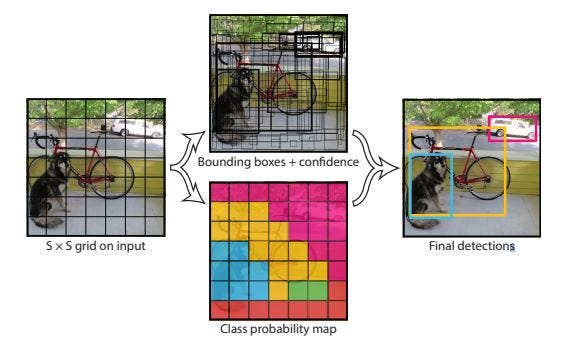

In [ ]:
import numpy as np
import tensorflow as tf
from keras import Model
from keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
import cv2

weights_path = './yolov3.weights'
output_path = './checkpoints/yolov3.tf'

## Structure and Scale 


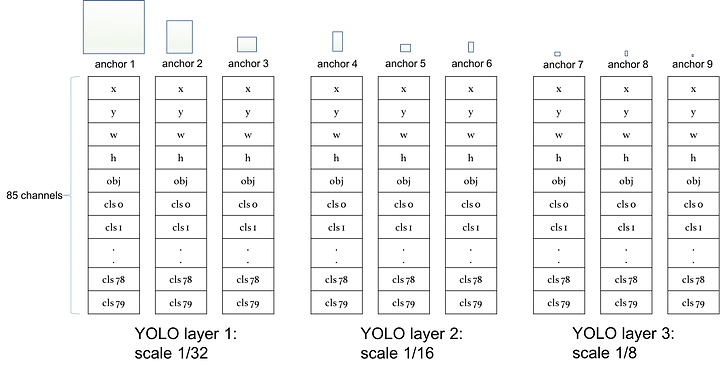



In [ ]:
yolo_max_boxes = 100
num_classes = 80

def conv_block(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm)(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def residual_block(x, filters):
    prev = x
    x = conv_block(x, filters // 2, 1)
    x = conv_block(x, filters, 3)
    x = Add()([prev, x])
    return x


def darknet_block(x, filters, blocks):
    x = conv_block(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = residual_block(x, filters)
    return x

## Anchors for bounding boxes 


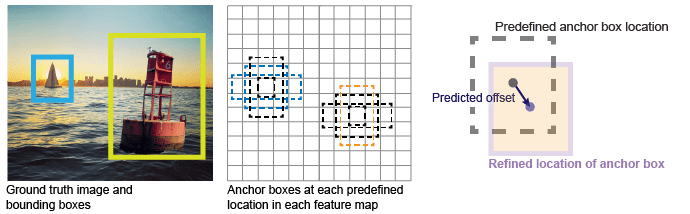

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

def yolo_detection_output(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = conv_block(x, filters * 2, 3)
        x = conv_block(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

def meshgrid(n_a, n_b):

    return [
        tf.reshape(tf.tile(tf.range(n_a), [n_b]), (n_b, n_a)),
        tf.reshape(tf.repeat(tf.range(n_b), n_a), (n_b, n_a))
    ]


def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    grid = meshgrid(grid_size[1],grid_size[0])
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

## Darknet


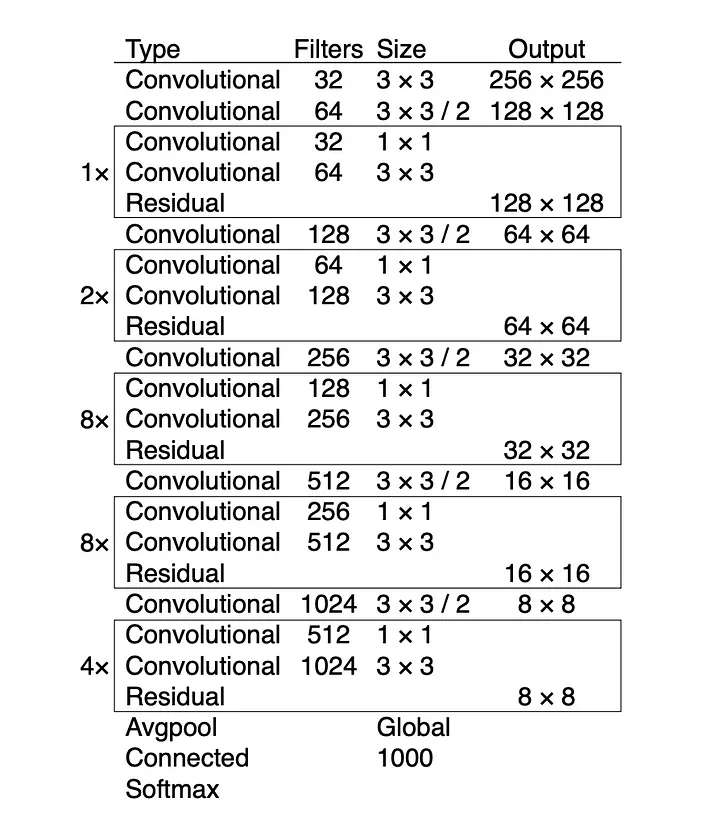

In [ ]:
def darknet_53(name=None):
    x = inputs = Input([None, None, 3])
    x = conv_block(x, 32, 3)
    x = darknet_block(x, 64, 1)
    x = darknet_block(x, 128, 2)
    x = route1 = darknet_block(x, 256, 8)
    x = route2 = darknet_block(x, 512, 8)
    x = darknet_block(x, 1024, 4)
    return tf.keras.Model(inputs, (route1, route2, x), name=name)

## Yolo Layers


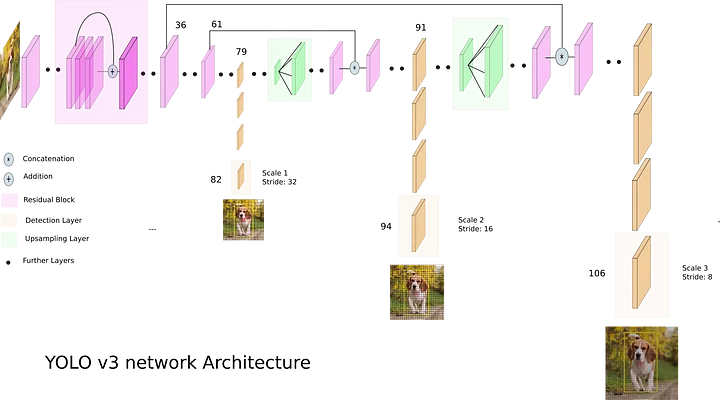

In [ ]:
def yolo_conv_block(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            x = conv_block(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = conv_block(x, filters, 1)
        x = conv_block(x, filters * 2, 3)
        x = conv_block(x, filters, 1)
        x = conv_block(x, filters * 2, 3)
        x = conv_block(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

## Non Max Suppression with Confidence and IOU


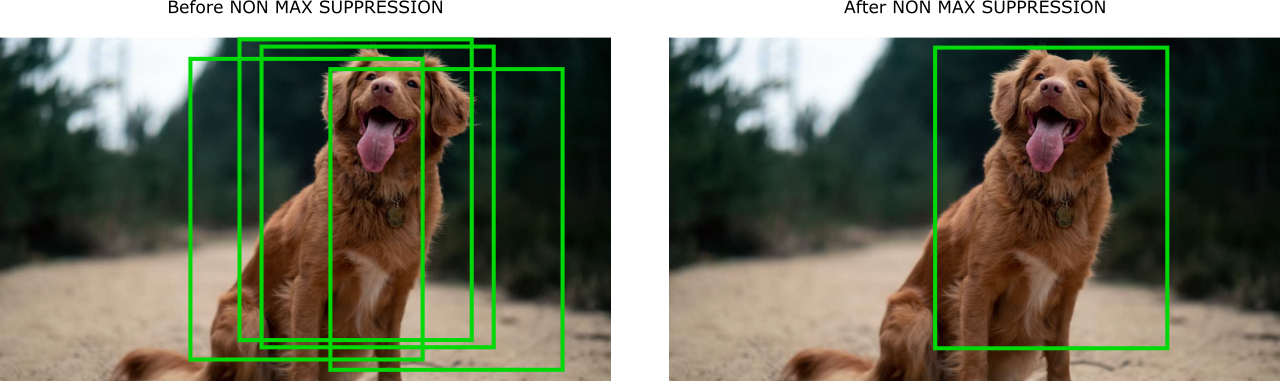

In [ ]:
def yolo_nms(outputs, classes=80):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    
    scores = confidence * class_probs

    dscores = tf.squeeze(scores, axis=0)
    scores = tf.reduce_max(dscores,[1])
    bbox = tf.reshape(bbox,(-1,4))
    classes = tf.argmax(dscores,1)
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        boxes=bbox,
        scores=scores,
        max_output_size=yolo_max_boxes,
        iou_threshold=0.5,
        score_threshold=0.5,
        soft_nms_sigma=0.5
    )
    
    num_valid_nms_boxes = tf.shape(selected_indices)[0]

    selected_indices = tf.concat([selected_indices,tf.zeros(yolo_max_boxes-num_valid_nms_boxes, tf.int32)], 0)
    selected_scores = tf.concat([selected_scores,tf.zeros(yolo_max_boxes-num_valid_nms_boxes,tf.float32)], -1)

    boxes=tf.gather(bbox, selected_indices)
    boxes = tf.expand_dims(boxes, axis=0)
    scores=selected_scores
    scores = tf.expand_dims(scores, axis=0)
    classes = tf.gather(classes,selected_indices)
    classes = tf.expand_dims(classes, axis=0)
    valid_detections=num_valid_nms_boxes
    valid_detections = tf.expand_dims(valid_detections, axis=0)

    return boxes, scores, classes, valid_detections

## Full Model Implementation

In [ ]:
def yolo_v3_model():
    x = inputs = Input([416, 416, 3], name='input')

    route1, route2, x = darknet_53(name='yolo_darknet')(x)

    x = yolo_conv_block(512, name='yolo_conv_0')(x)
    output_0 = yolo_detection_output(512, len(yolo_anchor_masks[0]), num_classes, name='yolo_output_0')(x)

    x = yolo_conv_block(256, name='yolo_conv_1')((x, route2))
    output_1 = yolo_detection_output(256, len(yolo_anchor_masks[1]), num_classes, name='yolo_output_1')(x)

    x = yolo_conv_block(128, name='yolo_conv_2')((x, route1))
    output_2 = yolo_detection_output(128, len(yolo_anchor_masks[2]), num_classes, name='yolo_output_2')(x)

    boxes_0 = Lambda(lambda x: yolo_boxes(x, yolo_anchors[yolo_anchor_masks[0]], num_classes), name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, yolo_anchors[yolo_anchor_masks[1]], num_classes), name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, yolo_anchors[yolo_anchor_masks[2]], num_classes), name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x), name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

## Loading Pretrained Weights

In [ ]:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            print("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

yolo = yolo_v3_model()
yolo.summary()
print('model created')

load_darknet_weights(yolo, weights_path)
print('weights loaded')

img = np.random.random((1, 416, 416, 3)).astype(np.float32)
output = yolo(img)
print('sanity check passed')

yolo.save_weights(output_path)
print('weights saved')

## Detection

In [ ]:
classes_path = './coco.names'
weights_path = './checkpoints/yolov3.tf'
img_size = 416
image_path = './input_city.jpg'
output_path = './output.jpg'
num_classes = 80

def preprocess_image(x_train, size):
    x_train = tf.expand_dims(x_train, 0)
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train


def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (0, 255, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
    return img

yolo = yolo_v3_model()

yolo.load_weights(weights_path).expect_partial()

class_names = [c.strip() for c in open(classes_path).readlines()]

img_raw = tf.image.decode_image(
    open(image_path, 'rb').read(), channels=3)

img = preprocess_image(img_raw, img_size)

boxes, scores, classes, nums = yolo(img)

for i in range(nums[0]):
    print('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite(output_path, img)
print('output saved to: {}'.format(output_path))